In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import math
from timeit import default_timer as timer
from datetime import datetime, timedelta
import numba


In [2]:
pd.options.display.max_rows=500
pd.options.display.max_columns=500
%load_ext autoreload
%autoreload 2


In [3]:
all_df = pd.read_pickle('../data/ml-ta-all-data-20190416.pkl.gz', compression='gzip')
print('Data loaded')
print(all_df.shape)

Data loaded
(15780, 1243)


In [4]:
train_df = all_df

In [5]:
target_col = 'target'

numeric_cols = []

for col in train_df.columns:
    if train_df[col].dtype.name in ['object', 'category']:
        print(col, train_df[col].dtype.name)
    elif train_df[col].dtype.name != 'int8':
        numeric_cols.append(col)

print(numeric_cols)

one_week_bollinger_prediction category
two_week_bollinger_prediction category
four_week_bollinger_prediction category
eight_week_bollinger_prediction category
twelve_week_bollinger_prediction category
twenty_six_week_bollinger_prediction category
fifty_two_week_bollinger_prediction category
one_week_bollinger_type category
two_week_bollinger_type category
four_week_bollinger_type category
eight_week_bollinger_type category
twelve_week_bollinger_type category
twenty_six_week_bollinger_type category
fifty_two_week_bollinger_type category
symbol category
GICSSector category
GICSIndustryGroup category
GICSIndustry category
['lastTradePriceOnly', 'adjustedPrice', 'volume', 'previousClose', 'change', 'changeInPercent', '52WeekHigh', '52WeekLow', 'changeFrom52WeekHigh', 'changeFrom52WeekLow', 'percebtChangeFrom52WeekHigh', 'percentChangeFrom52WeekLow', 'allordpreviousclose', 'allordchange', 'allorddayshigh', 'allorddayslow', 'allordpercebtChangeFrom52WeekHigh', 'allordpercentChangeFrom52WeekL

In [6]:
## Prep data for training to enable feature selection

# Train and fit encoders
from processing_constants import BOLLINGER_PREDICTION_COLUMNS, BOLLINGER_VALUE_COLUMNS
from sklearn.preprocessing import LabelEncoder 

symbol_encoder = LabelEncoder()
# need to keep symbol for dividing up data later - so make copy of symbol for tranforming into a numeric
train_df['symbolc'] = train_df['symbol']
train_df['symbolc'] = symbol_encoder.fit_transform(train_df['symbolc'].values)

GICSSector_encoder = LabelEncoder()
train_df['GICSSector'] = GICSSector_encoder.fit_transform(train_df['GICSSector'].values)

GICSIndustryGroup_encoder = LabelEncoder()
train_df['GICSIndustryGroup'] = GICSIndustryGroup_encoder.fit_transform(train_df['GICSIndustryGroup'].values)

GICSIndustry_encoder = LabelEncoder()
train_df['GICSIndustry'] = GICSIndustry_encoder.fit_transform(train_df['GICSIndustry'].values)


for col in BOLLINGER_PREDICTION_COLUMNS:
    bollinger_prediction_encoder = LabelEncoder()
    train_df[col] = bollinger_prediction_encoder.fit_transform(train_df[col].values)

for col in BOLLINGER_VALUE_COLUMNS:
    bollinger_value_encoder = LabelEncoder()
    train_df[col] = bollinger_value_encoder.fit_transform(train_df[col].values)
    
    
# Apply standard scaler
from sklearn import preprocessing

# Scale all numeric columns excluding target col
scale_cols = []

for col in train_df.columns:
    if col in numeric_cols and col != target_col:
        scale_cols.append(col)
        
print('Scaling', len(scale_cols), 'of', train_df.shape[1], 'cols')

scaler = preprocessing.RobustScaler()

train_df[scale_cols] = scaler.fit_transform(train_df[scale_cols])

# Fix NaNs

train_df[scale_cols] = train_df[scale_cols].fillna(0)

Scaling 1008 of 1244 cols


/Users/neilkloot/anaconda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/neilkloot/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [7]:
def one_hot_encode_field(df, column_name, categories):
    new_cols = pd.get_dummies(df[column_name])
    new_cols = new_cols.astype('int8', errors='ignore')

    new_cols.T.reindex(categories).T.fillna(0)
    
    name_map = {}
    # rename the categories
    for val in categories:
        name_map[val] = val

    new_cols.rename(name_map, axis=1, inplace=True)
    
    # Remove the original column
    df.drop([column_name], axis=1, inplace=True)
    
    # Return df with new cols 
    return pd.concat([df, new_cols], axis=1)



In [9]:
from sklearn.preprocessing import LabelEncoder

def prep_class_index(df, column_name, categories):
    class_encoder = LabelEncoder()
    class_vals = df[column_name].get_values()
#     print(class_vals)
    class_vals = class_vals.reshape(-1, 1)
#     print(class_vals)
    class_encoder.fit(class_vals)
    df['class_index'] = class_encoder.transform(class_vals)
    
    # Return df with new target index col
    return df


In [10]:
bins = [-99.07692719, -13.13461361, -3.00000238, 0.,9.25964718, 1493.]
bin_names = ['strong_sell', 'sell', 'hold', 'buy', 'strong_buy']


In [11]:
# prep data for training with one hot encoding
discretised_df = train_df
discretised_df['class'] = pd.cut(discretised_df['target'], bins=bins,labels=bin_names)
discretised_df = prep_class_index(discretised_df, 'class', bin_names)
discretised_df = one_hot_encode_field(discretised_df, 'class', bin_names)


/Users/neilkloot/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/neilkloot/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
# Create X and y data sets
y_df = discretised_df[bin_names]
X_df = discretised_df.drop(bin_names, axis=1)
X_df.drop(['target'], axis=1, inplace=True)

# X = X_df.values
# y = y_df.values

In [13]:
from numpy import array

def split_train_test_random(train_proportion=0.8):
    list_train_x = list()
    list_train_y_oh = list()
    list_train_y_le = list()
    list_train_symbols = list()

    list_test_x = list()
    list_test_y_oh = list()
    list_test_y_le = list()
    list_test_symbols = list()

    symbols = discretised_df['symbol'].unique()

    for symbol in symbols:
        # Filter to model data for this symbol and re-set the pandas indexes
        model_data = discretised_df.loc[discretised_df['symbol'] == symbol]
        
        train_df = model_data.sample(frac=train_proportion)
        test_df = model_data.drop(train_df.index)

        # Create target data set
        train_target_df_oh = train_df[bin_names]
        train_target_df_le = train_df['class_index']
        test_target_df_oh = test_df[bin_names]
        test_target_df_le = test_df['class_index']

        # Remove cols not in X array
        train_df.drop(bin_names, axis=1, inplace=True)
        train_df.drop(['symbol'], axis=1, inplace=True)
        train_df.drop(['target', 'class_index'], axis=1, inplace=True)
        test_df.drop(bin_names, axis=1, inplace=True)
        test_df.drop(['symbol'], axis=1, inplace=True)
        test_df.drop(['target', 'class_index'], axis=1, inplace=True)

        # nuber of features
        n_features = model_data.shape[1]

        # step over the first 80% of the history one time step at a time - training
#         print('Adding ',train_proportion*100,'% values to train')
        for val_num in range(len(train_df)-1):
            list_train_x.append(train_df.iloc[val_num:val_num+1, :].values)
            list_train_y_oh.append(train_target_df_oh.iloc[val_num:val_num+1, :].values)
            list_train_y_le.append(train_target_df_le.iloc[val_num:val_num+1].values)
            list_train_symbols.append(symbol)

        # step over the last 20% of the history one time step at a time - test
#         print('Adding ',(100 - (train_proportion*100)),'% values to test')
        for val_num in range(len(test_df)-1):
            list_test_x.append(test_df.iloc[val_num:val_num+1, :].values)
            list_test_y_oh.append(test_target_df_oh.iloc[val_num:val_num+1, :].values)
            list_test_y_le.append(test_target_df_le.iloc[val_num:val_num+1].values)
            list_test_symbols.append(symbol)


    train_x = array(list_train_x)
    train_y_oh = array(list_train_y_oh)
    train_y_le = array(list_train_y_le)
    train_symbols = array(list_train_symbols)

    test_x = array(list_test_x)
    test_y_oh = array(list_test_y_oh)
    test_y_le = array(list_test_y_le)
    test_symbols = array(list_test_symbols)
    
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[2])
    train_y_oh = train_y_oh.reshape(train_y_oh.shape[0], train_y_oh.shape[2])
    train_y_le = train_y_le.reshape(train_y_le.shape[0])
    test_x = test_x.reshape(test_x.shape[0], test_x.shape[2])
    test_y_oh = test_y_oh.reshape(test_y_oh.shape[0], test_y_oh.shape[2])
    test_y_le = test_y_le.reshape(test_y_le.shape[0])
    
    print('-'*20)
    print('Overall totals')

    print(' - train X shape: ', train_x.shape)
    print(' - train y one hot shape: ', train_y_oh.shape)
    print(' - train y label encoder shape: ', train_y_le.shape)
    print(' - train symbols lookup shape: ', train_symbols.shape)

    print(' - test X shape: ', test_x.shape)
    print(' - test y one hot shape: ', test_y_oh.shape)
    print(' - test y label encoder shape: ', test_y_le.shape)
    print(' - test symbols lookup shape: ', test_symbols.shape)

    return train_x, train_y_oh, train_y_le, train_symbols, test_x, test_y_oh, test_y_le, test_symbols


In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

rounds = 5

for _ in range(rounds):
    train_x, train_y_oh, train_y_le, train_symbols, test_x, test_y_oh, test_y_le, test_symbols = split_train_test_random(0.8)

    name = 'DecisionTreeClassifier'
    clf = DecisionTreeClassifier(max_depth=5)
    print('Training', name,'round',_)
    clf.fit(train_x, train_y)
    print('Predicting', name)
    pred_y = clf.predict(test_x)
#     print(pred_y)
    print('\nScoring', name)
    score = accuracy_score(test_y, pred_y)

    print('Accuracy:', score)


    # Compute confusion matrix
    cm = confusion_matrix(test_y.argmax(axis=1), pred_y.argmax(axis=1))
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm, bin_names)

    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, bin_names, title='Normalized confusion matrix')

In [ ]:
cols_to_remove = bin_names.copy()
cols_to_remove.extend(['symbol'])
cols = discretised_df.drop(cols_to_remove, axis=1).columns.values

feature_importance_df = pd.DataFrame({
    'column_name': cols,
    'importance': clf.feature_importances_
})

feature_importance_df.sort_values('importance', ascending=False)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

names = ["Nearest Neighbors", 
         "Decision Tree", 
         "Random Forest", 
         "AdaBoost", 
         "Naive Bayes", 
         "QDA",
#          "Linear SVM", 
         "RBF SVM", 
         "Gaussian Process"
        ]

classifiers = [
    KNeighborsClassifier(5),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=5)),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
#     SVC(kernel="linear", C=0.025),
    SVC(),
    GaussianProcessClassifier(1.0 * RBF(1.0))]

train_x, train_y_oh, train_y_le, train_symbols, test_x, test_y_oh, test_y_le, test_symbols = split_train_test_random(0.8)


# iterate over classifiers
for name, clf in zip(names, classifiers):
    print('Training', name)
    clf.fit(train_x, train_y_le)
    print('Scoring', name)
    pred_y = clf.predict(test_x)
    score = accuracy_score(test_y_le, pred_y)

    print('Accuracy:', score)


    # Compute confusion matrix
#     cm = confusion_matrix(test_y_le.argmax(axis=1), pred_y.argmax(axis=1))
    cm = confusion_matrix(test_y_le, pred_y)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm, bin_names)

    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, bin_names, title='Normalized confusion matrix')

    print('-'*20)


--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training Decision Tree
Scoring Decision Tree
Accuracy: 0.3940954342602128
Confusion matrix, without normalization
[[202  74  99 128  89]
 [104 247  56  72  66]
 [136  48 102 134 147]
 [ 92  44  64 238 156]
 [ 48  26  64 118 359]]
Normalized confusion matrix for Decision Tree
[[0.34 0.12 0.17 0.22 0.15]
 [0.19 0.45 0.1  0.13 0.12]
 [0.24 0.08 0.18 0.24 0.26]
 [0.15 0.07 0.11 0.4  0.26]
 [0.08 0.04 0.1  0.19 0.58]]
--------------------
Training Random Forest
Scoring Random Forest
Accuracy: 0.4898729831788534
Confusion matrix, without normalization
[[230  77 106 119  60]
 [ 83 281  73  56  52]
 [ 92  44 181 104 146]
 [ 85  35  52 310 112]
 [ 21  14  65  90 42

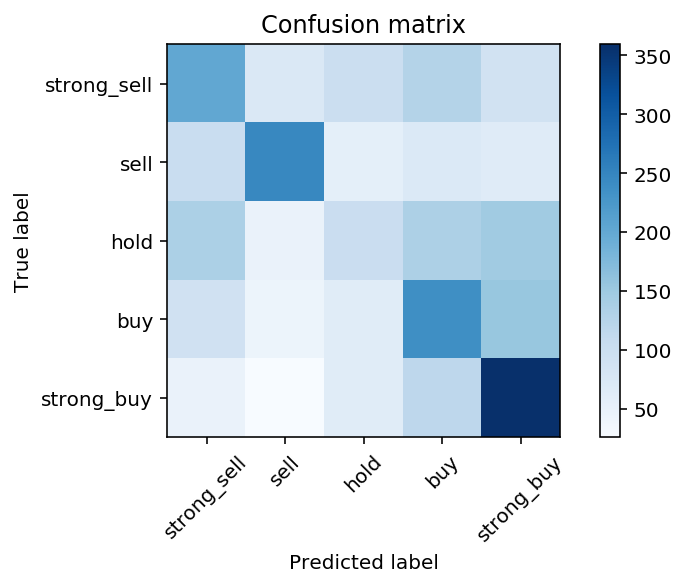

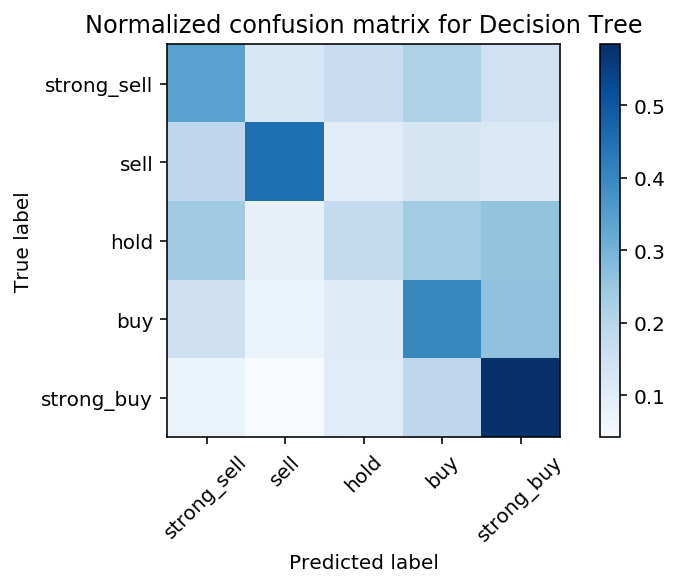

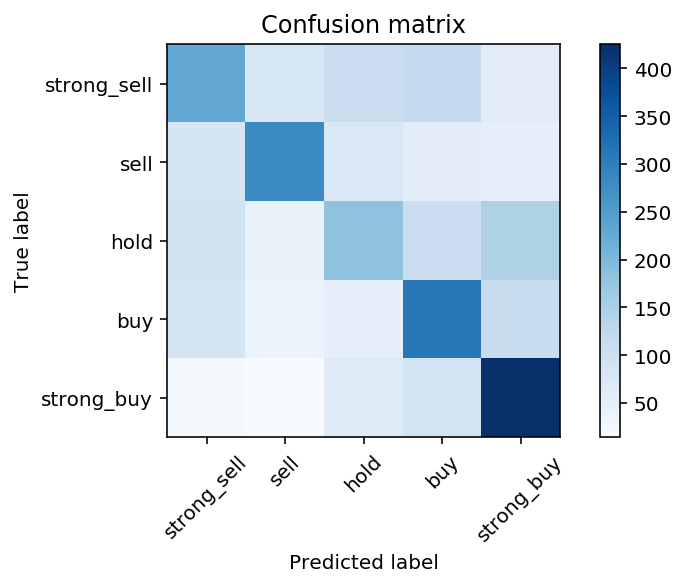

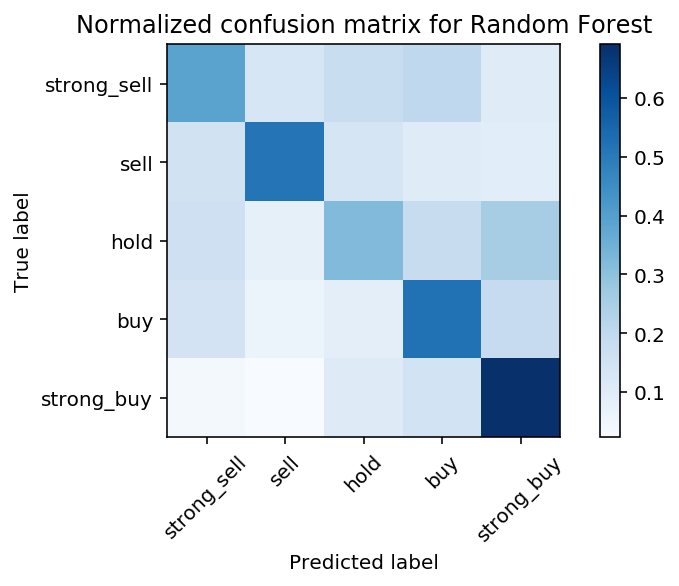

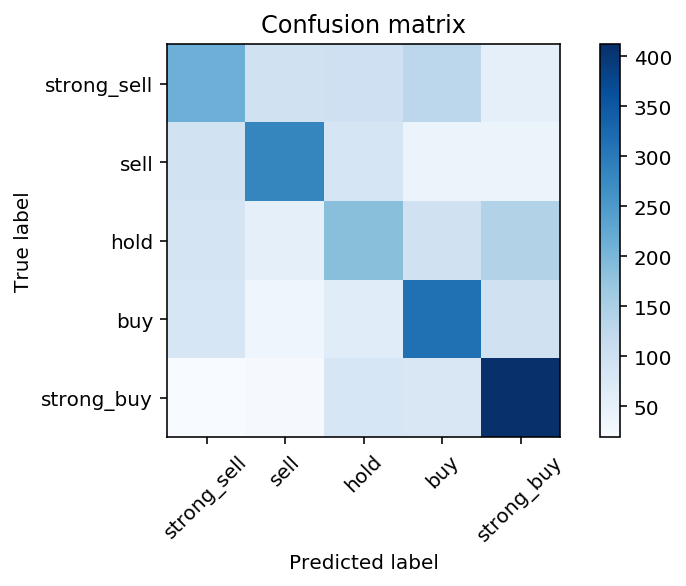

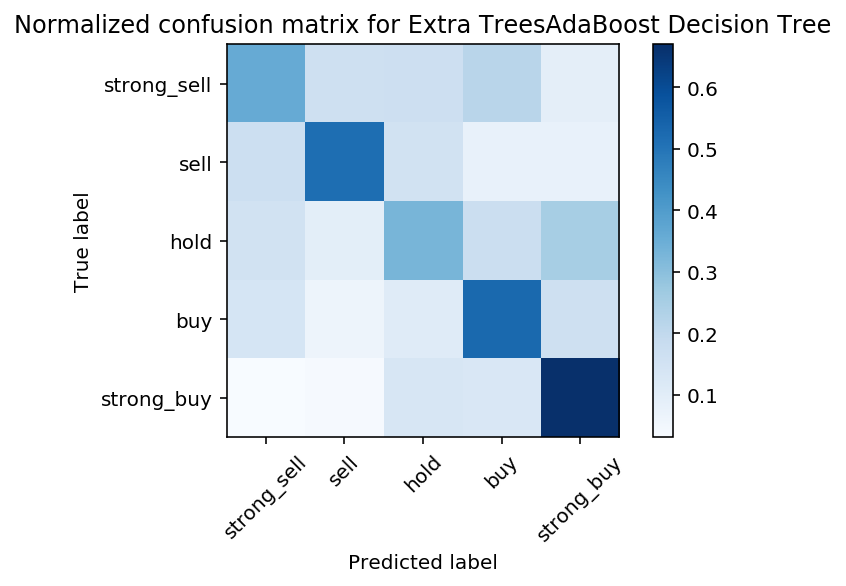

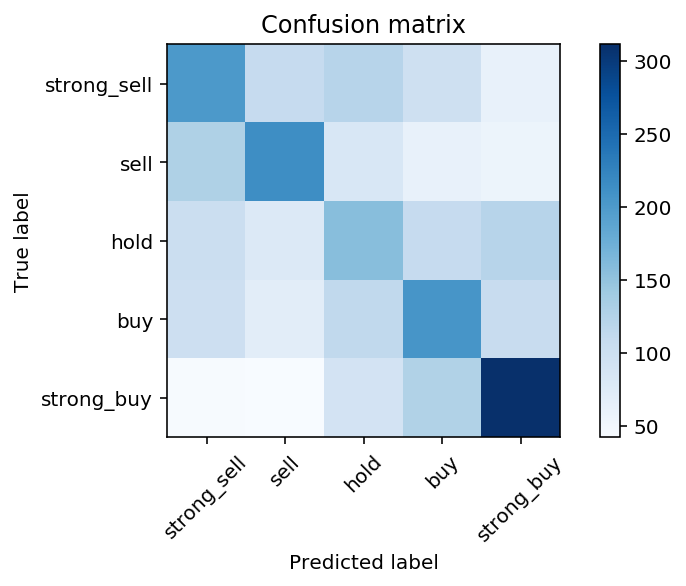

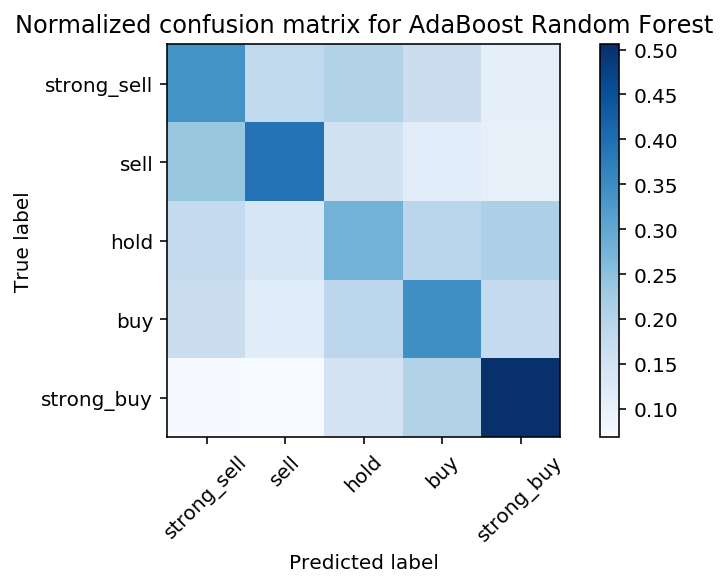

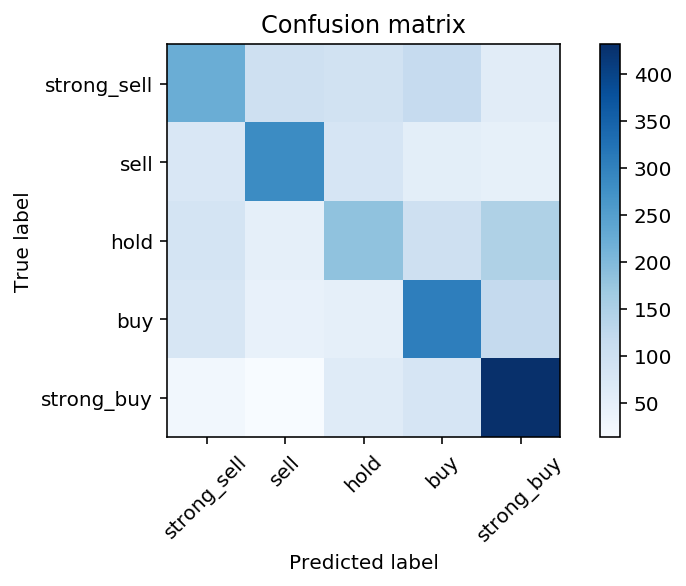

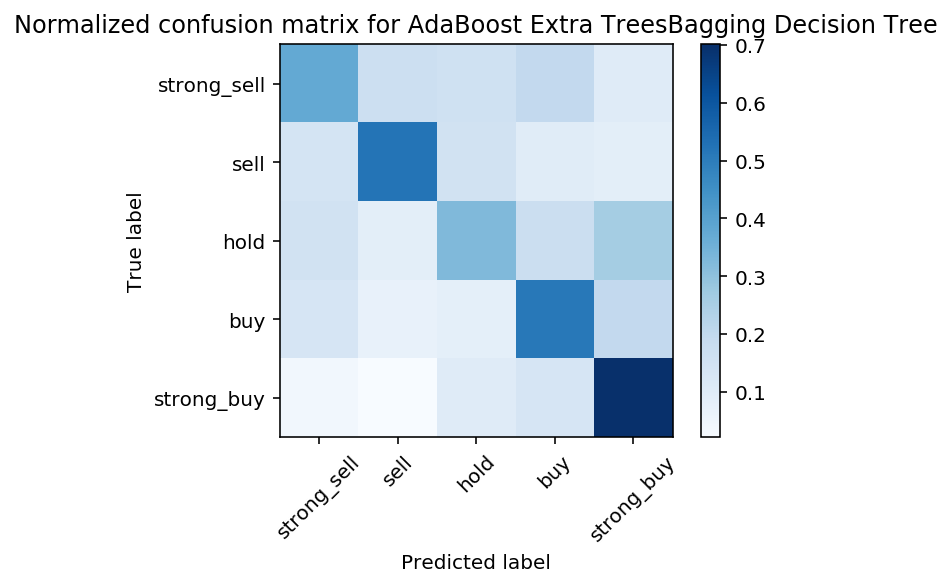

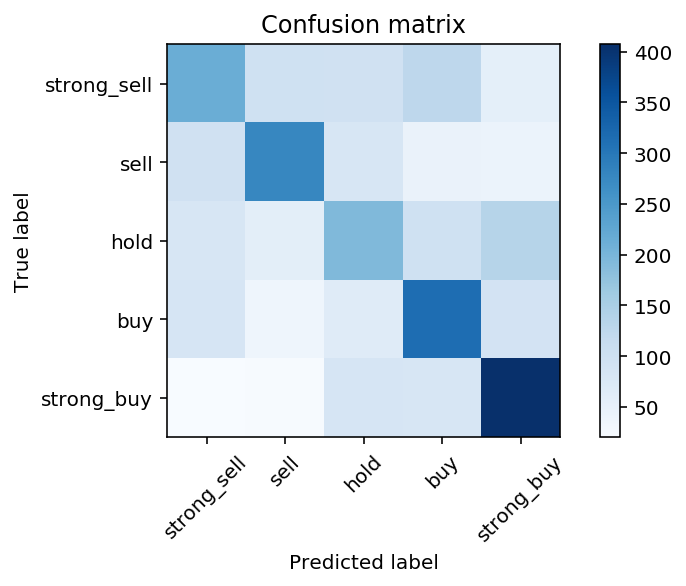

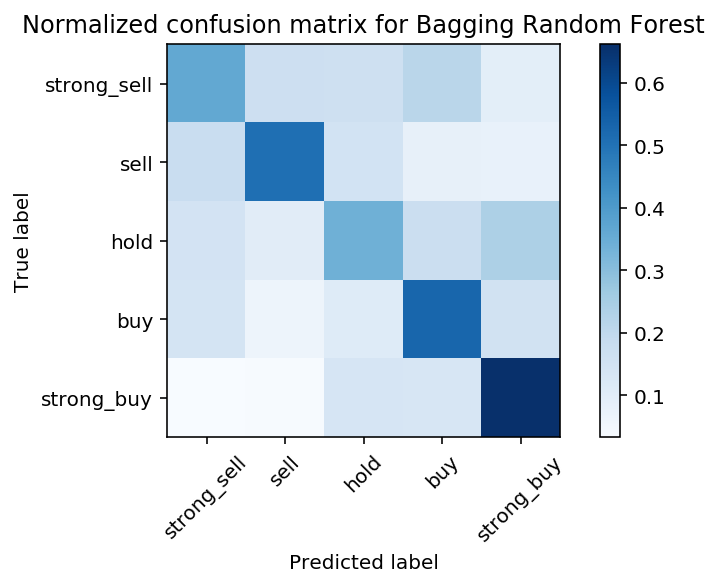

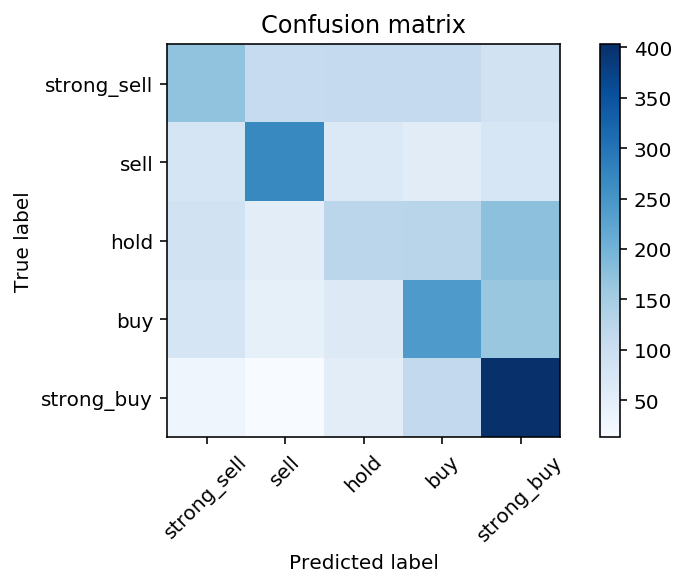

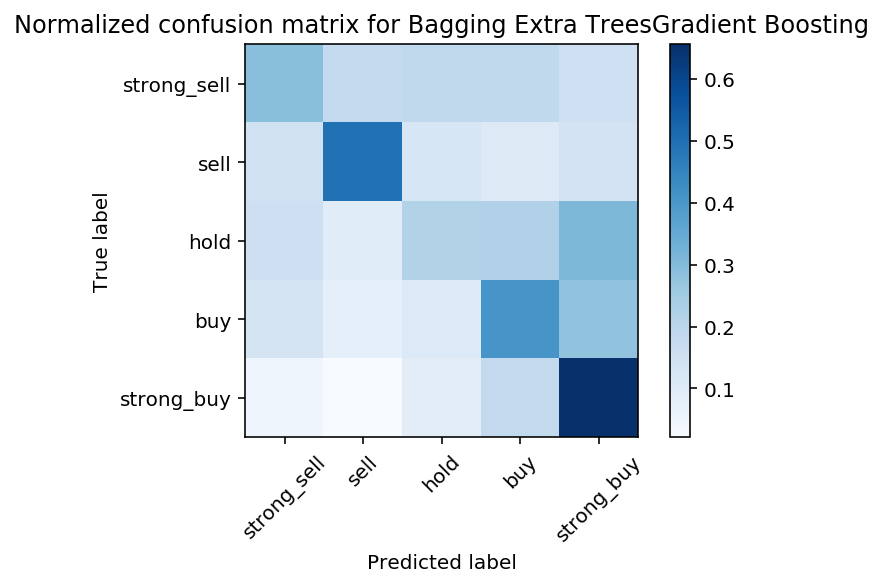

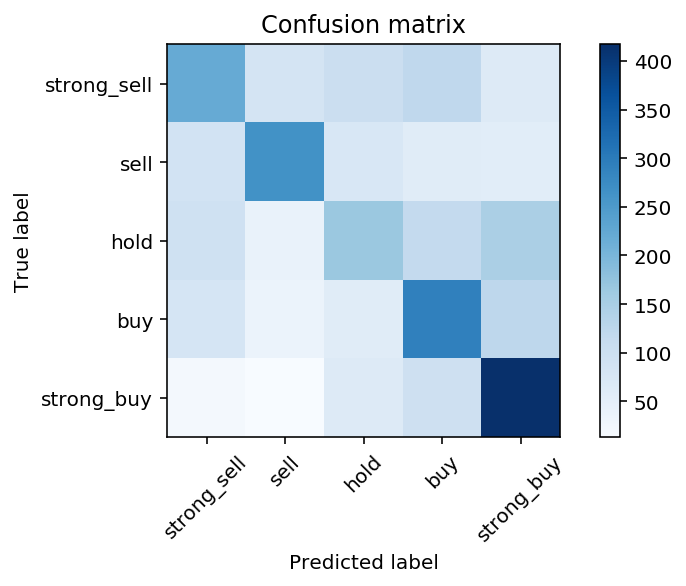

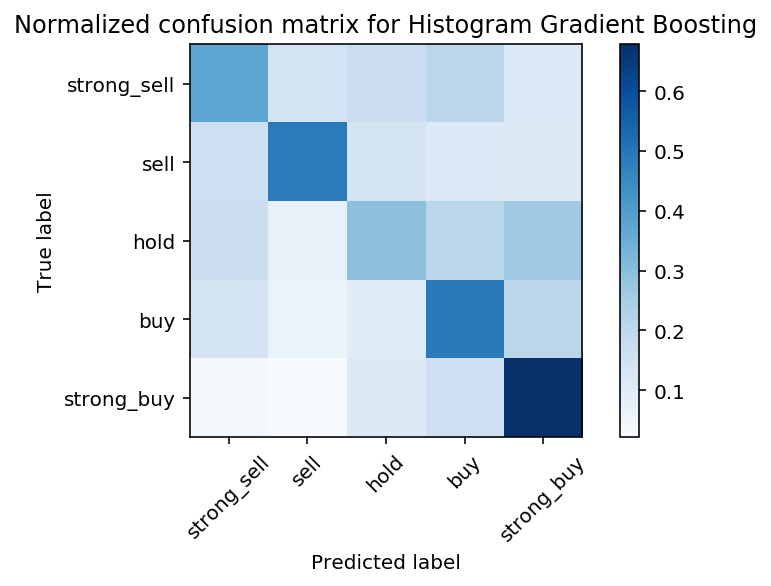

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomTreesEmbedding, ExtraTreesClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

names = [
    "Decision Tree", 
    "Random Forest", 
    "Extra Trees"
    "AdaBoost Decision Tree",
    "AdaBoost Random Forest",
    "AdaBoost Extra Trees"
    "Bagging Decision Tree",
    "Bagging Random Forest",
    "Bagging Extra Trees"
    "Gradient Boosting",
    "Histogram Gradient Boosting",
]


classifiers = [
    DecisionTreeClassifier(max_depth=15, max_features=1086, min_samples_split=3, min_samples_leaf=193),
    RandomForestClassifier(max_depth=20, n_estimators=505, max_features=1242, min_samples_split=2, min_samples_leaf=1),
    ExtraTreesClassifier(n_estimators=1012, max_depth=65, max_features=1242, min_samples_split=2, min_samples_leaf=1),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=15, max_features=1086, min_samples_split=3, min_samples_leaf=193), n_estimators=10),
    AdaBoostClassifier(RandomForestClassifier(max_depth=20, n_estimators=505, max_features=1242, min_samples_split=2, min_samples_leaf=1), n_estimators=10),
    AdaBoostClassifier(ExtraTreesClassifier(n_estimators=1012, max_depth=65, max_features=1242, min_samples_split=2, min_samples_leaf=1), n_estimators=10),
    BaggingClassifier(DecisionTreeClassifier(max_depth=15, max_features=1086, min_samples_split=3, min_samples_leaf=193), n_estimators=10),
    BaggingClassifier(RandomForestClassifier(max_depth=20, n_estimators=505, max_features=1242, min_samples_split=2, min_samples_leaf=1), n_estimators=10),
    BaggingClassifier(ExtraTreesClassifier(n_estimators=1012, max_depth=65, max_features=1242, min_samples_split=2, min_samples_leaf=1), n_estimators=10),
    GradientBoostingClassifier(),
    HistGradientBoostingClassifier(max_iter=343, max_leaf_nodes=623, learning_rate=0.1, min_samples_leaf=2, l2_regularization=0.),
]

train_x, train_y_oh, train_y_le, train_symbols, test_x, test_y_oh, test_y_le, test_symbols = split_train_test_random(0.8)


# iterate over classifiers
for name, clf in zip(names, classifiers):
    print('Training', name)
    clf.fit(train_x, train_y_le)
    print('Scoring', name)
    pred_y = clf.predict(test_x)
    score = accuracy_score(test_y_le, pred_y)

    print('Accuracy:', score)


    # Compute confusion matrix
#     cm = confusion_matrix(test_y_le.argmax(axis=1), pred_y.argmax(axis=1))
    cm = confusion_matrix(test_y_le, pred_y)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm, bin_names)

    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix for', name)
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, bin_names, title='Normalized confusion matrix for %s' % (name))

    print('-'*20)


In [ ]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


space = [
    Integer(6, 15, name='max_depth'),
    Integer(1, 1242, name='max_features'),
    Integer(2, 100, name='min_samples_split'),
    Integer(1, 200, name='min_samples_leaf')
]

model = DecisionTreeClassifier()

@use_named_args(space)
def objective(**params):
    print('Setting params', params)
    model.set_params(**params)

    print('Retrieiving split data')
    train_x, train_y_oh, train_y_le, train_symbols, test_x, test_y_oh, test_y_le, test_symbols = split_train_test_random(0.8)

    print('Training')
    model.fit(train_x, train_y_le)

    print('Executing predictions')
    pred_y = model.predict(test_x)

    score = accuracy_score(test_y_le, pred_y)
    print('Score:', score)

    return -score


res_gp = gp_minimize(objective, space, n_calls=100, random_state=0)

"Best score=%.4f" % res_gp.fun

print("""Best parameters:
- max_depth=%d
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3]))

# 50 calls
# - max_depth=7
# - max_features=1242
# - min_samples_split=2
# - min_samples_leaf=100
# ---
# 100 calls
# - max_depth=15
# - max_features=1086
# - min_samples_split=3
# - min_samples_leaf=193


In [ ]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


space = [
    Integer(500, 1000, name='n_estimators'),
    Integer(20, 70, name='max_depth'),
#     Integer(800, 1242, name='max_features'),
#     Integer(2, 10, name='min_samples_split'),
#     Integer(1, 10, name='min_samples_leaf')
]

model = RandomForestClassifier(max_features=1242, min_samples_split=2, min_samples_leaf=1)

@use_named_args(space)
def objective(**params):
    print('Setting params', params)
    model.set_params(**params)

    print('Retrieiving split data')
    train_x, train_y_oh, train_y_le, train_symbols, test_x, test_y_oh, test_y_le, test_symbols = split_train_test_random(0.8)

    print('Training')
    model.fit(train_x, train_y_le)

    print('Executing predictions')
    pred_y = model.predict(test_x)

    score = accuracy_score(test_y_le, pred_y)
    print('Score:', score)
    print('-'*10)

    return -score


res_gp = gp_minimize(objective, space, n_calls=100, random_state=0)

"Best score=%.4f" % res_gp.fun

print("""Best parameters for Random Forest:
- n_estimators=%d
- max_depth=%d
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3],
                           res_gp.x[4]))
# - n_estimators=250
# - max_depth=27
# - max_features=1016
# - min_samples_split=2
# - min_samples_leaf=1

# - n_estimators=400
# - max_depth=32
# - max_features=1242
# - min_samples_split=2
# - min_samples_leaf=1

#'n_estimators': 1000, 'max_depth': 20
#'n_estimators': 505, 'max_depth': 20



In [23]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.callbacks import DeltaYStopper

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score


space = [
    Integer(700, 1200, name='n_estimators'),
    Integer(30, 120, name='max_depth'),
#     Integer(600, 1242, name='max_features'),
#     Integer(2, 50, name='min_samples_split'),
#     Integer(1, 50, name='min_samples_leaf')
]

model = ExtraTreesClassifier(max_features=1242, min_samples_split=2, min_samples_leaf=1)
deltay = DeltaYStopper(0.005, 3)

@use_named_args(space)
def objective(**params):
    print('Setting params', params)
    model.set_params(**params)

    print('Retrieiving split data')
    train_x, train_y_oh, train_y_le, train_symbols, test_x, test_y_oh, test_y_le, test_symbols = split_train_test_random(0.8)

    print('Training')
    model.fit(train_x, train_y_le)

    print('Executing predictions')
    pred_y = model.predict(test_x)

    score = accuracy_score(test_y_le, pred_y)
    print('Score:', score)
    print('-'*10)
    
    return -score


res_gp = gp_minimize(objective, space, n_calls=50, callback=deltay, random_state=0)

"Best score=%.4f" % res_gp.fun

print("""Best parameters for Extra Trees:
- n_estimators=%d
- max_depth=%d""" % (res_gp.x[0], res_gp.x[1]))
      
# - max_features=%d
# - min_samples_split=%d
# - min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
#                             res_gp.x[2], res_gp.x[3],
#                            res_gp.x[4]))
# - n_estimators=250
# - max_depth=27
# - max_features=1016
# - min_samples_split=2
# - min_samples_leaf=1



Setting params {'n_estimators': 996, 'max_depth': 106}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.47751458976999656
----------
Setting params {'n_estimators': 1129, 'max_depth': 106}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.46996223824236183
----------
Setting params {'n_estimators': 1

/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 1200, 'max_depth': 30}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4709921043597666
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 1200, 'max_depth': 30}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.46618606247854444
----------
Setting params {'n_estimators': 1200, 'max_depth': 30}
Retrieiving split data


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.47133539306556815
----------
Setting params {'n_estimators': 700, 'max_depth': 30}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.46172330930312394
----------
Setting params {'n_estimators': 702, 'max_depth': 120}
Retrieiving split data
--------------------
Overall totals

/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4740817027119808
----------
Setting params {'n_estimators': 1198, 'max_depth': 120}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.47614143494679023
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 1200, 'max_depth': 120}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4668726398901476
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 1200, 'max_depth': 120}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4785444558874013
----------
Setting params {'n_estimators': 1200, 'max_depth': 120}
Retrieiving split data


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4782011671815997
----------
Setting params {'n_estimators': 703, 'max_depth': 31}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4740817027119808
----------
Setting params {'n_estimators': 709, 'max_depth': 30}
Retrieiving split data
--------------------
Overall totals
 -

/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 1200, 'max_depth': 120}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4654994850669413
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 702, 'max_depth': 30}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4627531754205287
----------
Setting params {'n_estimators': 707, 'max_depth': 120}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.466529351184346
----------
Setting params {'n_estimators': 1196, 

/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 1200, 'max_depth': 120}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.47579814624098865
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 1200, 'max_depth': 120}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.46584277377274286
----------
Setting params {'n_estimators': 706, 'max_depth': 30}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4819773429454171
----------
Setting params {'n_estimators': 702

/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 702, 'max_depth': 120}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4627531754205287
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 1196, 'max_depth': 30}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.47957432200480604
----------
Setting params {'n_estimators': 1194, 'max_depth': 30}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4806041881222108
----------
Setting params {'n_estimators': 119

/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 703, 'max_depth': 120}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.47579814624098865
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 1200, 'max_depth': 30}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4747682801235839
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 1200, 'max_depth': 30}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.45966357706831446
----------
Setting params {'n_estimators': 700, 'max_depth': 119}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4668726398901476
----------
Setting params {'n_estimators': 702

/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 1200, 'max_depth': 30}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4606934431857192
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 702, 'max_depth': 30}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.47545485753518707
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'n_estimators': 702, 'max_depth': 30}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4703055269481634
----------
Setting params {'n_estimators': 1199, 'max_depth': 118}
Retrieiving split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Training
Executing predictions
Score: 0.4740817027119808
----------
Best parameters for Extra Trees:
- n

In [22]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.callbacks import DeltaYStopper

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

import datetime


@use_named_args(space)
def objective(**params):
    print('Setting params', params)
    model.set_params(**params)

#     # re-use same data for 4 rounds, then re-retrieve
#     if rounds%4 == 0:
#         print('Re-retrieiving split data')
#         train_x, train_y_oh, train_y_le, train_symbols, test_x, test_y_oh, test_y_le, test_symbols = split_train_test_random(0.8)

    print(datetime.datetime.now().strftime("%H:%M:%S"), ' Training')
    model.fit(train_x, train_y_le)

    print(datetime.datetime.now().strftime("%H:%M:%S"), ' Executing predictions')
    pred_y = model.predict(test_x)

    score = accuracy_score(test_y_le, pred_y)
    print('Score:', score)
    print('-'*10)
    
    return -score

model = HistGradientBoostingClassifier(learning_rate=0.1, min_samples_leaf=2, l2_regularization=0.)
deltay = DeltaYStopper(0.0025, 3)
print(datetime.datetime.now().strftime("%H:%M:%S"), ' Getting split data')
train_x, train_y_oh, train_y_le, train_symbols, test_x, test_y_oh, test_y_le, test_symbols = split_train_test_random(0.8)

space = [
#     Real(0.1, 1., name='learning_rate'),
    Integer(150, 800, name='max_iter'),
    Integer(600, 1000, name='max_leaf_nodes')
#     Integer(2, 50, name='min_samples_leaf'),
#     Real(0., 1., name='l2_regularization')
]


res_gp = gp_minimize(objective, space, n_calls=100, callback=deltay, random_state=0)

"Best score=%.4f" % res_gp.fun

# print("""Best parameters for Histogram Gradient Booster:
# - learning_rate=%f
# - max_iter=%d
# - max_leaf_nodes=%d
# - min_samples_leaf=%d
# - l2_regularization=%f""" % (res_gp.x[0], res_gp.x[1], 
#                             res_gp.x[2], res_gp.x[3],
#                            res_gp.x[4]))

print("""Best parameters for Histogram Gradient Booster:
- max_iter=%d
- max_leaf_nodes=%d""" % (res_gp.x[0], res_gp.x[1]))

# 'learning_rate': 0.1
# 'max_iter': 100, 
#'max_leaf_nodes': 500
# 'min_samples_leaf': 2
# 'l2_regularization': 


12:54:23  Getting split data
--------------------
Overall totals
 - train X shape:  (12417, 1242)
 - train y one hot shape:  (12417, 5)
 - train y label encoder shape:  (12417,)
 - train symbols lookup shape:  (12417,)
 - test X shape:  (2913, 1242)
 - test y one hot shape:  (2913, 5)
 - test y label encoder shape:  (2913,)
 - test symbols lookup shape:  (2913,)
Setting params {'max_iter': 535, 'max_leaf_nodes': 938}
12:54:38  Training
14:03:26  Executing predictions
Score: 0.4806041881222108
----------
Setting params {'max_iter': 708, 'max_leaf_nodes': 939}
14:03:27  Training
15:21:54  Executing predictions
Score: 0.48575351870923444
----------
Setting params {'max_iter': 555, 'max_leaf_nodes': 754}
15:21:56  Training
16:33:34  Executing predictions
Score: 0.48575351870923444
----------
Setting params {'max_iter': 343, 'max_leaf_nodes': 623}
16:33:35  Training
17:37:26  Executing predictions
Score: 0.4963954685890834
----------
Setting params {'max_iter': 327, 'max_leaf_nodes': 791}
1

/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
04:04:13  Training
05:11:07  Executing predictions
Score: 0.4881565396498455
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
05:11:09  Training
06:17:01  Executing predictions
Score: 0.4881565396498455
----------
Setting params {'max_iter': 797, 'max_leaf_nodes': 999}
06:17:02  Training
07:35:36  Executing predictions
Score: 0.48541023000343286
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
07:35:38  Training
08:42:06  Executing predictions
Score: 0.4881565396498455
----------
Setting params {'max_iter': 154, 'max_leaf_nodes': 601}
08:42:07  Training
09:41:13  Executing predictions
Score: 0.48781325094404393
----------
Setting params {'max_iter': 163, 'max_leaf_nodes': 602}
09:41:16  Training
10:40:07  Executing predictions
Score: 0.48746996223824235
----------
Setting params {'max_iter': 798, 'max_leaf_nodes': 999}
10:40:08  Training
12:01:23  Executing predictions
Score: 0.48541023000343286
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
12:01:24  Training
13:07:01  Executing predictions
Score: 0.4881565396498455
----------
Setting params {'max_iter': 154, 'max_leaf_nodes': 600}
13:07:03  Training
14:05:48  Executing predictions
Score: 0.4806041881222108
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
14:05:50  Training
15:12:12  Executing predictions
Score: 0.4881565396498455
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
15:12:13  Training
16:19:02  Executing predictions
Score: 0.4881565396498455
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
16:19:04  Training
17:25:12  Executing predictions
Score: 0.4881565396498455
----------
Setting params {'max_iter': 799, 'max_leaf_nodes': 994}
17:25:14  Training
18:47:35  Executing predictions
Score: 0.47785787847579814
----------
Setting params {'max_iter': 152, 'max_leaf_nodes': 999}
18:47:36  Training
20:03:19  Executing predictions
Score: 0.483693786474425
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
20:03:21  Training
21:07:20  Executing predictions
Score: 0.4881565396498455
----------
Setting params {'max_iter': 153, 'max_leaf_nodes': 602}
21:07:21  Training
22:06:09  Executing predictions
Score: 0.486096807415036
----------
Setting params {'max_iter': 153, 'max_leaf_nodes': 996}
22:06:11  Training
23:21:10  Executing predictions
Score: 0.4802608994164092
----------
Setting params {'max_iter': 158, 'max_leaf_nodes': 602}
23:21:11  Training
00:20:26  Executing predictions
Score: 0.48781325094404393
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
00:20:28  Training
01:27:17  Executing predictions
Score: 0.4881565396498455
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
01:27:19  Training
02:34:18  Executing predictions
Score: 0.4881565396498455
----------
Setting params {'max_iter': 796, 'max_leaf_nodes': 999}
02:34:20  Training
03:56:56  Executing predictions
Score: 0.48575351870923444
----------
Setting params {'max_iter': 152, 'max_leaf_nodes': 606}
03:56:58  Training
04:56:31  Executing predictions
Score: 0.490216271884655
----------
Setting params {'max_iter': 798, 'max_leaf_nodes': 997}
04:56:33  Training
06:15:20  Executing predictions
Score: 0.4819773429454171
----------
Setting params {'max_iter': 157, 'max_leaf_nodes': 600}
06:15:22  Training
07:12:32  Executing predictions
Score: 0.4806041881222108
----------
Setting params {'max_iter': 156, 'max_leaf_nodes': 998}
07:12:33  Training
08:26:53  Executing predictions
Score: 0.4785444558874013
----------
Setting params {'max_iter': 155, 'max_leaf_nodes': 601}
08:26:55  Training
09:25:52  Executing predictions
Score: 0.4884998283556471
---

/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
10:47:19  Training
11:53:10  Executing predictions
Score: 0.4881565396498455
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
11:53:12  Training
12:58:56  Executing predictions
Score: 0.4881565396498455
----------
Setting params {'max_iter': 153, 'max_leaf_nodes': 605}
12:58:58  Training
13:57:36  Executing predictions
Score: 0.4884998283556471
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 796, 'max_leaf_nodes': 999}
13:57:38  Training
15:19:18  Executing predictions
Score: 0.48575351870923444
----------
Setting params {'max_iter': 155, 'max_leaf_nodes': 600}
15:19:20  Training
16:18:02  Executing predictions
Score: 0.4806041881222108
----------
Setting params {'max_iter': 800, 'max_leaf_nodes': 603}
16:18:04  Training
17:24:19  Executing predictions
Score: 0.49124613800205974
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
17:24:21  Training
18:30:05  Executing predictions
Score: 0.4881565396498455
----------
Setting params {'max_iter': 150, 'max_leaf_nodes': 998}
18:30:07  Training
19:45:07  Executing predictions
Score: 0.4768280123583934
----------
Setting params {'max_iter': 794, 'max_leaf_nodes': 601}
19:45:09  Training
20:48:31  Executing predictions
Score: 0.490216271884655
----------
Setting params {'max_iter': 791, 'max_leaf_nodes': 998}
20:48:32  Training
22:07:33  Executing predictions
Score: 0.48541023000343286
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
22:07:35  Training
23:14:20  Executing predictions
Score: 0.4881565396498455
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
23:14:22  Training
00:21:27  Executing predictions
Score: 0.4881565396498455
----------


/Users/neilkloot/anaconda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Setting params {'max_iter': 800, 'max_leaf_nodes': 600}
00:21:29  Training
01:28:31  Executing predictions
Score: 0.4881565396498455
----------
Setting params {'max_iter': 151, 'max_leaf_nodes': 603}
01:28:33  Training
02:27:59  Executing predictions
Score: 0.49467902506007555
----------
Best parameters for Histogram Gradient Booster:
- max_iter=343
- max_leaf_nodes=623


In [20]:
print(res_gp.x[0], res_gp.x[1], res_gp.x[2])

200 650 0.0
